# Make Notebook Run within IBM Watson

In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
# START CODE BLOCK
# cos2file - takes an object from Cloud Object Storage and writes it to file on container file system.
# Uses the IBM project_lib library.
# See https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/project-lib-python.html
# Arguments:
# p: project object defined in project token
# data_path: the directory to write the file
# filename: name of the file in COS

import os
def cos2file(p,data_path,filename):
    data_dir = p.project_context.home + data_path
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    open( data_dir + '/' + filename, 'wb').write(p.get_file(filename).read())

# file2cos - takes file on container file system and writes it to an object in Cloud Object Storage.
# Uses the IBM project_lib library.
# See https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/project-lib-python.html
# Arguments:
# p: prooject object defined in project token
# data_path: the directory to read the file from
# filename: name of the file on container file system

import os
def file2cos(p,data_path,filename):
    data_dir = p.project_context.home + data_path
    path_to_file = data_dir + '/' + filename
    if os.path.exists(path_to_file):
        file_object = open(path_to_file, 'rb')
        p.save_data(filename, file_object, set_project_asset=True, overwrite=True)
    else:
        print("file2cos error: File not found")
# END CODE BLOCK

In [3]:
cos2file(project, '/data', 'movie_reviews.csv')

# OpenScale Tutorial

## First, let's start by creating the predictive model. 
This is a text classfier to predict customer churn based on movie reviews. We'll use the same data as we did in Module 4.

The input data is plain text of movie reviews. We'll first clean, tokenize and lemmatize the words, then convert them to a numeric matrix of tf-idf.

We'll do this in two parts, so that the deployed model can have a numeric feature matrix as its input.

In [4]:
#!pip install spacy

In [5]:
#!python -m spacy download en

In [6]:
import os
import json
import sklearn
import pickle
import sys
import re
import pandas as pd
import numpy as np
import spacy
nlp = spacy.load('en')
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from string import punctuation, printable
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
movie_reviews = pd.read_csv('../data/movie_reviews.csv')
print(movie_reviews.head())

                                              review  label
0  b"arnold schwarzenegger has been an icon for a...      0
1  b"good films are hard to find these days . \ng...      1
2  b"quaid stars as a man who has taken up the pr...      1
3  b'we could paraphrase michelle pfieffer\'s cha...      0
4  b"kolya is one of the richest films i've seen ...      1


In [8]:
X = movie_reviews['review']
y = movie_reviews['label'].rename('*label*')

# The target column must have a name that does not appear as a word/token in the corpus

In [9]:
# clean up and convert the plain text
good_characters = 'abcdefghijklmnopqrstuvwxyz '
def lemmatize(doc):    
    doc = str(doc).lower()
    doc = "".join([char for char in doc if char in good_characters])
    doc = nlp(doc)
    tokens = [re.sub("\W+","",token.lemma_.lower()) for token in doc ]
    return ' '.join(w for w in tokens if (w not in ENGLISH_STOP_WORDS) and (len(w)>1))

X = X.apply(lemmatize)
print(X.head())

0    barnold schwarzenegger icon action enthusiast ...
1    bgood film hard day ngreat film rare nproof li...
2    bquaid star man proffesion dragonslayer pron f...
3    bwe paraphrase michelle pfieffer character dan...
4    bkolya rich film pron time nzdenek sverak play...
Name: review, dtype: object


In [10]:
X_train, X_test, y_train, y_test = [data.reset_index(drop = True) for 
                                    data in train_test_split(X,y, random_state = 101)]

print(X_train.head(), X_test.head(), y_train.head(), y_test.head())

0    bin daylight sylvester stallone break new grou...
1    bwalt disney studio finally meet pron match lu...
2    bmy giant begin monologue funny distinctive pr...
3    bcountrie legal rule law principle seriously f...
4    byet brainless teen flick surprise drug sex ns...
Name: review, dtype: object 0    bwelcome pron ohso typical sequel nit try twic...
1    bwith television gay character infamous ellen ...
2    bnote consider portion follow text spoiler nbe...
3    bso pron thirty year later oscar felix nthat e...
4    bnearly film tim burton direct homage horror g...
Name: review, dtype: object 0    1
1    0
2    0
3    1
4    0
Name: *label*, dtype: int64 0    0
1    1
2    0
3    0
4    0
Name: *label*, dtype: int64


In [11]:
tf_idf = TfidfVectorizer(max_features = 10000).fit(X_train)
X_train_tfidf = tf_idf.transform(X_train).todense()
X_test_tfidf = tf_idf.transform(X_test).todense()
X_train_tfidf

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
# The vocabulary in the tf_idf is an unordered dictionary.
# we need to sort it so that we can associate words with coefficients
words = []
indices = []
for word, index in tf_idf.vocabulary_.items():
    words.append(word)
    indices.append(index)
    
sorted_index = np.argsort(indices)
sorted_words = np.array(words)[sorted_index]
print(sorted_words, len(sorted_words))

['aaron' 'abandon' 'abby' ... 'zorro' 'zucker' 'zwick'] 10000


In [13]:
# Convert the tf-idf (numeric) array to a pandas dataframe with feature columns
X_train_df = pd.DataFrame(X_train_tfidf)
X_test_df = pd.DataFrame(X_test_tfidf)
X_train_df.columns = sorted_words
X_test_df.columns = sorted_words
X_train_df.head()

,aaron,abandon,abby,abduction,aberdeen,abigail,ability,able,ably,aboard,...,zero,zetajone,zinger,zombie,zone,zoolander,zoom,zorro,zucker,zwick
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.102622,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


## We have converted our plain text to a dense DataFrame of tf-idf for the top 10,000 terms. 

### You will notice that nearly all of the cells are zero, and many of the words don't seem to be relevant to whether or not a customer is likely to churn. Words like "awful" and "wonderful" are likely correlated with customer satisfaction, but the implcation of words like 'zombie' and 'zoolander' are not as obvious.

### To reduce the complexity of the model, we will identify the 200 most significant words and rebuild a model just using these. Note that *most significant* does not mean most common -- it means the words that have the highest magnitude coefficient in the predictive model.

In [14]:
model = SGDClassifier(loss = 'log', max_iter = 1000, tol=1e-3).fit(X_train_df, y_train)
print('Training score: ', model.score(X_train_df, y_train))
print('Test score: ', model.score(X_test_df, y_test))
print('Confusion Matrix: \n', confusion_matrix(y_test, model.predict(X_test_df)))


Training score:  1.0
Test score:  0.838
Confusion Matrix: 
 [[207  43]
 [ 38 212]]


In [15]:
indices_of_positive_features = np.argsort(model.coef_)[0][::-1][:100]
indices_of_negative_features = np.argsort(model.coef_)[0][:100]

vocabulary = np.array(sorted_words)
positive_vocab = vocabulary[indices_of_positive_features]
negative_vocab = vocabulary[indices_of_negative_features]
print('20 most positive words: \n', positive_vocab[:20])
print('20 most negative words: \n', negative_vocab[:20])
significant_vocabulary = np.hstack([positive_vocab, negative_vocab])

20 most positive words: 
 ['great' 'fun' 'hilarious' 'war' 'matrix' 'good' 'life' 'performance'
 'quite' 'excellent' 'perfect' 'terrific' 'memorable' 'solid' 'truman'
 'frank' 'wonderful' 'town' 'trek' 'alien']
20 most negative words: 
 ['bad' 'waste' 'plot' 'suppose' 'boring' 'attempt' 'script' 'fail'
 'stupid' 'minute' 'nunfortunately' 'lame' 'nif' 'tv' 'poor' 'try' 'dull'
 'ridiculous' 'bore' 'talk']


## Review of signficant words

A quick check of the word clouds for positive and negative words gives us confidence that our model is working as expected:

### Positive Wordcloud
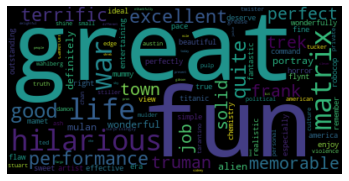


### Negative Wordcloud
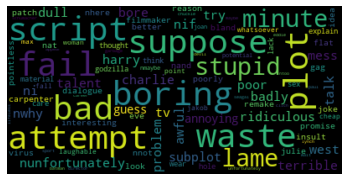

In terms of *Business Opportunity* these findings are not unexecpted. This provides important validation of a mathematical and measureable link between customer sentiment and business opportunities.


## Having found the most siginficant words, let us now build a TF-IDF Vectorizer focused only on these words

In [16]:
significant_tfidf = TfidfVectorizer(vocabulary = significant_vocabulary).fit(X_train)
X_train_significant_tfidf = significant_tfidf.transform(X_train).todense()
X_test_significant_tfidf = significant_tfidf.transform(X_test).todense()
print(X_train_significant_tfidf)
print(X_train_significant_tfidf.shape)

[[0.         0.08239727 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.03061426 0.0394801  0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.17691894 ... 0.         0.         0.06861491]
 [0.         0.0638857  0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(1500, 200)


In [17]:
# Save this trained TF-IDF Vectorizer for future use
with open('significant_tfidf.pkl', 'wb') as f:
    pickle.dump(significant_tfidf, f)

In [18]:
X_train_significant_df = pd.DataFrame(X_train_significant_tfidf)
X_test_significant_df = pd.DataFrame(X_test_significant_tfidf)
X_train_significant_df.columns = significant_tfidf.vocabulary_
X_test_significant_df.columns = significant_tfidf.vocabulary_
X_train_significant_df.head()

,great,fun,hilarious,war,matrix,good,life,performance,quite,excellent,...,maybe,devil,nmaybe,paul,pimp,lifeless,spawn,eddie,franklin,impression
0,0.000000,0.082397,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.079895,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.240428,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.030614,0.039480,0.0,0.000000,0.0,0.000000,0.029412,0.058523,0.076563,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.029841,0.000000,0.0,0.716766,0.0,0.101139,0.028669,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Save the training data, with `*label*` column.

## We will need this later

In [19]:
pd.concat([X_train_significant_df, y_train], axis =1).to_csv('../data/training_data.csv', index = False)

In [20]:
file2cos(project, '/data', 'training_data.csv')

## Let's now train a SGDClassifier using this smaller, more select data set and see how it performs

In [21]:
significant_model = SGDClassifier(loss = 'log', max_iter = 1000, tol=1e-3).fit(X_train_significant_df, y_train)
print('Training score: ', significant_model.score(X_train_significant_df, y_train))
print('Test score: ', significant_model.score(X_test_significant_df, y_test))
print('Confusion Matrix: \n', confusion_matrix(y_test, significant_model.predict(X_test_significant_df)))

Training score:  0.89
Test score:  0.782
Confusion Matrix: 
 [[162  88]
 [ 21 229]]


### On the test data, this preforms almost exactly as well as the orignal model which had 10,000 feature words, but this one has only 200 feature words -- it uses 98% less data!

## Now that we have a reasonably good model, let's deploy it to IBM Watson ML
You should already have an account with Watson Studio and credentials saved in ```~/.ibm/wml.json```.

If you need to create these credentials, please revisit the tutorial in Module 5


In [22]:
cos2file(project, '/ibm', 'wml.json')

In [23]:
# Import credentials from ~/.ibm/wml.json
wmlcreds_file = os.path.join(os.path.expanduser("~"),'ibm/wml.json')
# or set location of file manually:
wmlcreds_file = wmlcreds_file #replace with location of file if different than ~/.ibm/wml.json
with open(wmlcreds_file, "r") as wml_file:
        wmlcreds = json.load(wml_file)

# convert credentials to the correct dictoinary format
wml_credentials = {"apikey": wmlcreds['apikey'],
    "instance_id": wmlcreds['instance_id'],
    "url": wmlcreds['url'],}

print(wml_credentials.keys())

dict_keys(['apikey', 'instance_id', 'url'])


## Create a client to interact with Watson Machine Learning

In [24]:
#!pip install -U ibm-ai-openscale

In [25]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
client = WatsonMachineLearningAPIClient(wml_credentials)
print(client)

## Review deployed models and delete any unused models to make room for new deployments

In [36]:
client.repository.list_models()
#guid = 'insert model guid'
#client.repository.delete(guid)

------------------------------------  ---------------------  ------------------------  -----------------
GUID                                  NAME                   CREATED                   FRAMEWORK
7c153c3d-2643-4cd4-abab-b1cc65181ead  GermanCreditRiskModel  2020-05-01T13:52:33.736Z  mllib-2.3
0b4e0209-854e-4330-8ff6-11aac83e7981  Model200               2020-05-01T13:46:19.534Z  scikit-learn-0.20
------------------------------------  ---------------------  ------------------------  -----------------


'SUCCESS'

## Let's store the Model in the repository

In [37]:
significant_model

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [38]:
metadata = {client.repository.ModelMetaNames.NAME: "Model200",
            client.repository.ModelMetaNames.FRAMEWORK_NAME: "scikit-learn",
            client.repository.ModelMetaNames.FRAMEWORK_VERSION: sklearn.__version__
           }

model_details = client.repository.store_model(significant_model, meta_props=metadata)

model_uid = client.repository.get_model_uid(model_details)

client.repository.list_models()

------------------------------------  ---------------------  ------------------------  -----------------
GUID                                  NAME                   CREATED                   FRAMEWORK
c0cf0741-03e1-459d-b45c-1be045818ff3  Model200               2020-05-01T14:56:51.981Z  scikit-learn-0.20
7c153c3d-2643-4cd4-abab-b1cc65181ead  GermanCreditRiskModel  2020-05-01T13:52:33.736Z  mllib-2.3
------------------------------------  ---------------------  ------------------------  -----------------


## And now we deploy the model

In [39]:
deployment_details = client.deployments.create(artifact_uid=model_uid, name="Model1-deployment")
deployment_uid = deployment_details['metadata']['guid']
print(deployment_uid)
print(client.deployments.get_status(deployment_uid))



#######################################################################################

Synchronous deployment creation for uid: 'c0cf0741-03e1-459d-b45c-1be045818ff3' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='cb9e3572-328d-4e26-a226-452374a96c36'
------------------------------------------------------------------------------------------------


cb9e3572-328d-4e26-a226-452374a96c36
DEPLOY_SUCCESS


In [40]:
# We should now see a model and the corresponding online deployment
client.repository.list()

------------------------------------  ---------------------  ------------------------  -----------------  -----------------
GUID                                  NAME                   CREATED                   FRAMEWORK          TYPE
c0cf0741-03e1-459d-b45c-1be045818ff3  Model200               2020-05-01T14:56:51.981Z  scikit-learn-0.20  model
7c153c3d-2643-4cd4-abab-b1cc65181ead  GermanCreditRiskModel  2020-05-01T13:52:33.736Z  mllib-2.3          model
cb9e3572-328d-4e26-a226-452374a96c36  Model1-deployment      2020-05-01T14:56:59.095Z  scikit-learn-0.20  online deployment
6440bcbb-801a-4ee3-bd67-fd87367abeb0  GermanCreditRiskModel  2020-05-01T13:52:36.085Z  mllib-2.3          online deployment
------------------------------------  ---------------------  ------------------------  -----------------  -----------------


## Let's verify the deployment by sending it some data and getting a response

Let's send it a movie review and see if it thinks we are likely to churn.

In [41]:
good_movie_review = "This movie is really good. I really liked it. I want to watch it again. Excellent!"
# movie_review = "bad hated terrible awful horrible never"

### Lemmatize and tf-idf the text.
As before, we can't just send plain text like this. It needs to be cleaned, lemmatized and converted to a tf-idf numeric matrix, using the same methods that the model was first trained on

In [42]:
good_movie_review = lemmatize(good_movie_review)
good_movie_review = significant_tfidf.transform([good_movie_review]).todense()
good_movie_review = pd.DataFrame(good_movie_review)
good_movie_review.columns = significant_tfidf.vocabulary_
print(good_movie_review.head())

   great  fun  hilarious  war  matrix      good  life  performance  quite  \
0    0.0  0.0        0.0  0.0     0.0  0.291129   0.0          0.0    0.0   

   excellent  ...  maybe  devil  nmaybe  paul  pimp  lifeless  spawn  eddie  \
0   0.800117  ...    0.0    0.0     0.0   0.0   0.0       0.0    0.0    0.0   

   franklin  impression  
0       0.0         0.0  

[1 rows x 200 columns]


## We can now create a data payload and send this to the deployed model for prediction

In [43]:
values = good_movie_review.values.tolist()
payload = {'fields':list(significant_tfidf.vocabulary_), 'values': values}
scoring_url = deployment_details['entity']['scoring_url']
prediction = client.deployments.score(scoring_url, payload)

print(prediction)

{'fields': ['prediction', 'probability'], 'values': [[1, [0.014588766102542783, 0.9854112338974572]]]}


## Let's do the same with a bad movie review

In [44]:
bad_review = "I really hated this bad movie. it was awful. I want to quit. Horrible. terrible"
bad_review = lemmatize(bad_review)
bad_review = significant_tfidf.transform([bad_review]).todense()
bad_review = pd.DataFrame(bad_review)
bad_review.columns = significant_tfidf.vocabulary_
print(bad_review.head())

   great  fun  hilarious  war  matrix  good  life  performance  quite  \
0    0.0  0.0        0.0  0.0     0.0   0.0   0.0          0.0    0.0   

   excellent  ...  maybe  devil  nmaybe  paul  pimp  lifeless  spawn  eddie  \
0        0.0  ...    0.0    0.0     0.0   0.0   0.0       0.0    0.0    0.0   

   franklin  impression  
0       0.0         0.0  

[1 rows x 200 columns]


In [45]:
values = bad_review.values.tolist()
payload = {'fields':list(significant_tfidf.vocabulary_), 'values': values}
scoring_url = deployment_details['entity']['scoring_url']
prediction = client.deployments.score(scoring_url, payload)

print(prediction)

{'fields': ['prediction', 'probability'], 'values': [[0, [0.999257717232973, 0.0007422827670270853]]]}


### As you can see, we get a very different prediction for the bad review.

# OpenScale Configuration
## The next step is to link this deployed model to IBM Watson OpenScale to provide monitoring services

To get started, navigate to your `Dashboard` at https://cloud.ibm.com/

At the upper right, click on `Create Resource`. This will take you to the catalog of services offered in the IBM Watson Suite. We'll be using ``Watson OpenScale``, but you might want to take a minute to examine some of the many other offerings.

You can also use this link to take you directly to the OpenScale service: 

https://cloud.ibm.com/catalog/services/watson-openscale

### Create the service
If you're using the free lite plan, accept the default. You may change the `Service name` if you wish. In this example, I am calling my service `'OS-tutorial'`

On the right, click `Create` and then `'Launch Applicaton'`

### Setting up the service
You should now see the welcome message as shown below.
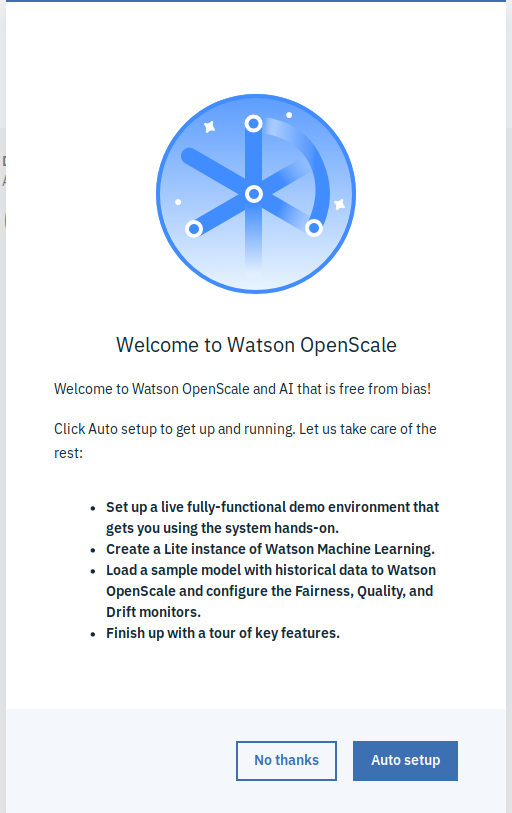

Click on `Auto setup`

It will take a few minutes as OpenScale configures some default services

When the Auto setup is complete, you should see the following dialog:
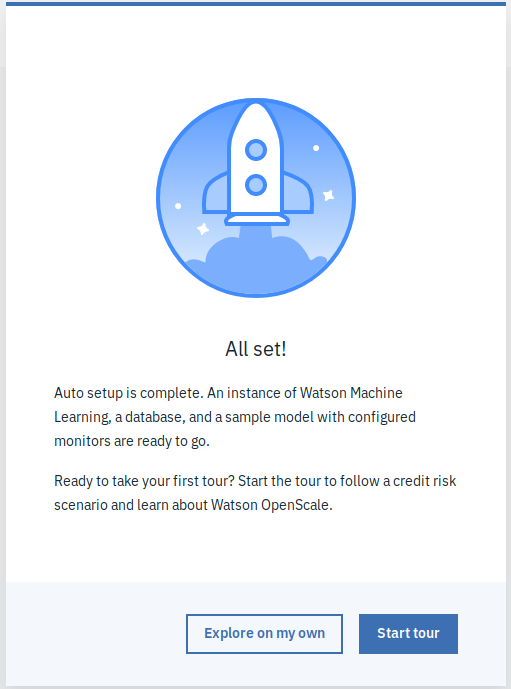

Click on `start tour`

The tour shows the German Credit Risk model as an example. You may spend some time exploring this. This example address issues such as fairness by gender, which is an important consideration in many models, especially where historically different demographic groups have been discriminated against.

In this model, the effect of gender or other demographic features is monitored by creating synthetic inputs in which all the data is the same except the demographic value has been altered, and then determining if a more favorable outcome would have resulted. This is equivalent to calculating the partial derivative with respect to the demographic value at a particular point in the response curve.

It can then suggest, and even auto-generate models that are demonstrable more fair.

OpenScale can also look for, and automatically address, selection bias and demographic imbalance in the training data set.

On a a more granular level, OpenScale can examine the decision-making process behind individual transactions, provide *explainability* for the outcome and assess fairness. It can also provide a list of the minimum changes necessary to alter the outcome.

When you are done examing the Credit Risk example, we will delete it and replace it with our churn-prediction model. Our model does not have a feature describing gender, race or other demographics, so some of the issues of fairness are not relevant.

Return to the Insights Dashboard and click on the *heart beat* (zig-zag) icon at the upper left.

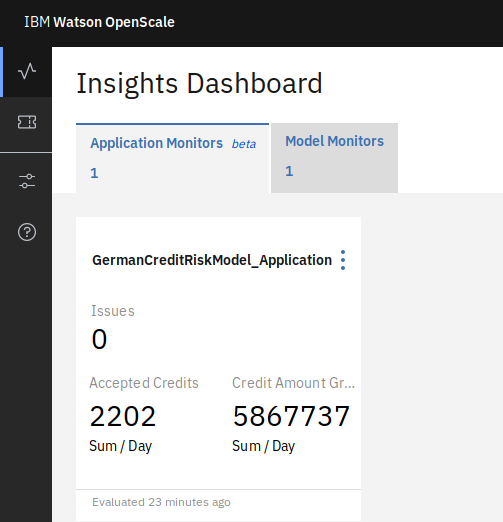

You should see the tile for the GermanCreditRiskModel_Application

Click on the drop-down list and select `Remove Application`


Next, go to the `Model Monitors` tab where you will see the tile 'GermanCreditRisk'. Again, select 'Remove Deployment' from the drop down list on this tile.

You should now see an empty Insights Dashboard and a message that says, "Add a deployed model to get started."

Click on `Add`

In the dialog box, select the churn prediction model we deployed previously in this tutorial and click `configure`.

On the next screen, click `configure monitors`.

Our data type is `numeric/categorical`, which may be the only option available, and our algorithim type is `Binary classification`.

Click `save`.

### Payload Logging
On the next screen, you should see the following message about Payload logging.

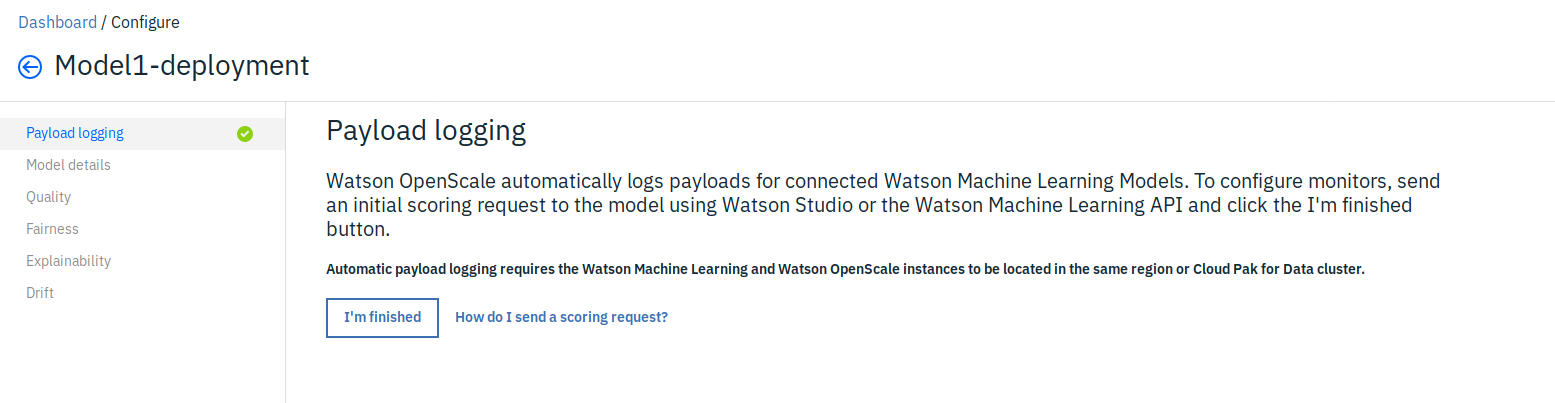

OpenScale needs to see an example of what the incoming data is expected to look like. So we need to send some example payloads for configuration.

Also on this page, you will see the details of the deployment and subscription and be able to download them as a json file.

## Send a scoring request
To send a score request, we need several things, a url of the deployed model, a client to send the data from python to the model and a payload or set of input data.

We created the WatsonMachineLearningAPIClient earlier in this tutorial

We'll use the same payload and scoring url as above.


In [46]:
# Send the payload for scoring and print the results
predictions = client.deployments.score(scoring_url, payload)
print(predictions)

{'fields': ['prediction', 'probability'], 'values': [[0, [0.999257717232973, 0.0007422827670270853]]]}


## Return results
When our payload has been sent sucessfully, we should see the results returned. These include the predictions (in this case, 1 for the first review and 0 for the second review), along with the corresponding predicted probabilities.

When this has been completed, return to the `Payload Logging` page and click `I'm finished` to complete the process.

You should then see the message, `Logging Activated Sucessfully`

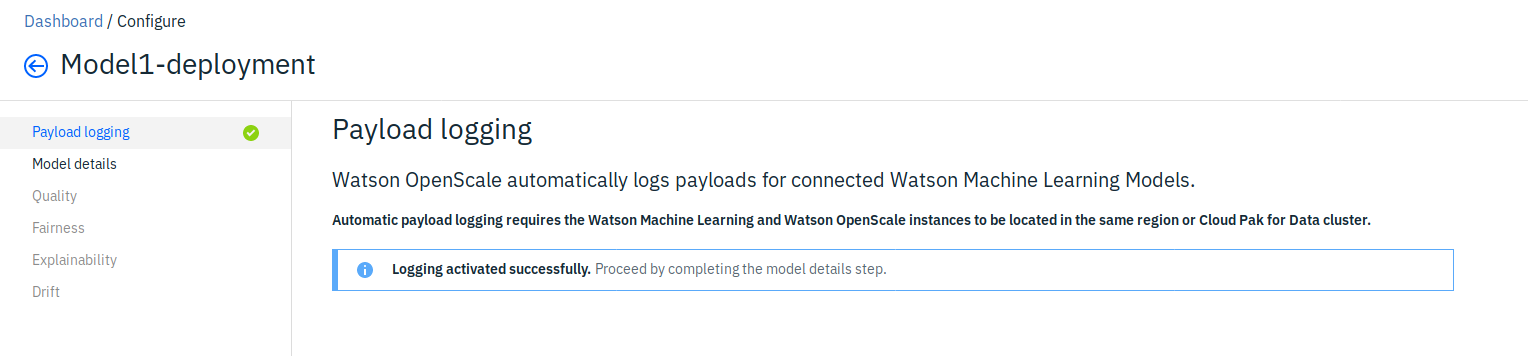

## Model Details Setup

You will now need to complete the model details setup.

Click on `model details` at the left and then, on the next screen, click `begin`

You have two options, `Manually configure monitors` and `Upload training data distribution`. We will manually configure the monitors.

Select this option and click `next`.

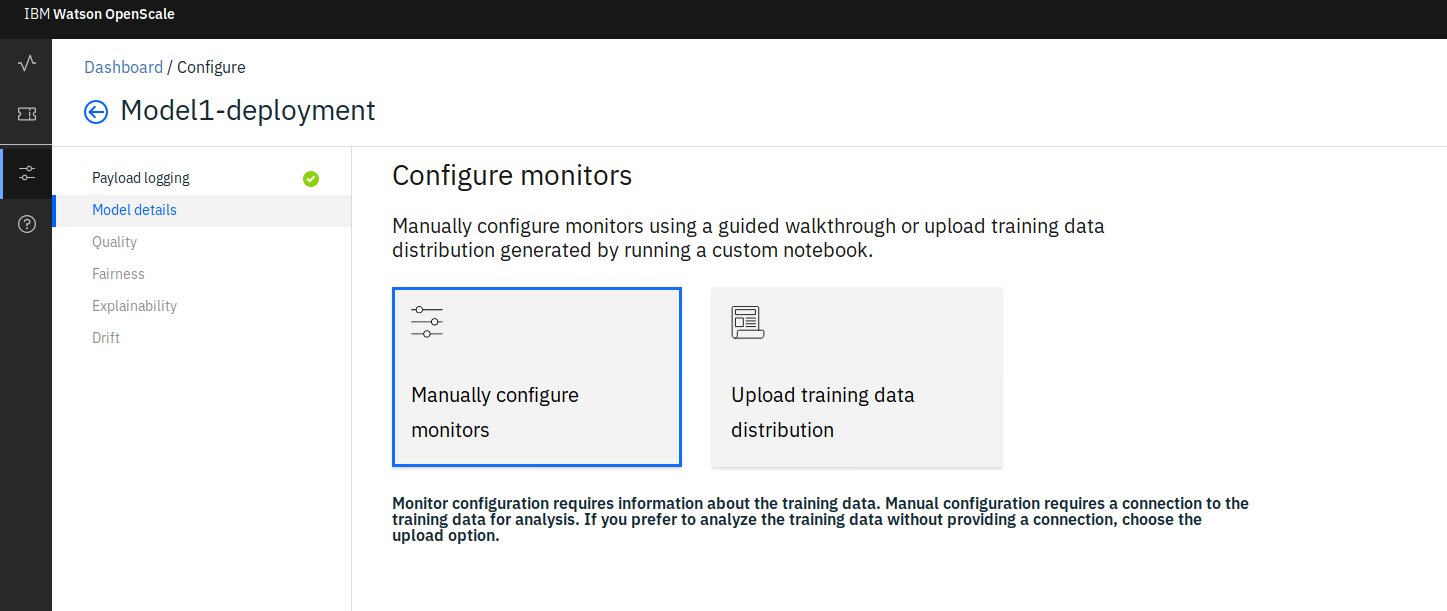

## Specify the location of the training data.

### We now need to create a Cloud Storage Object to store the training data.

You may review your list of resources using the following link:
https://cloud.ibm.com/resources

If you do not have a Cloud Object Storage, navigate to:
https://cloud.ibm.com/catalog

Click `Storage` from the left column and then the tile for `Object Storage`
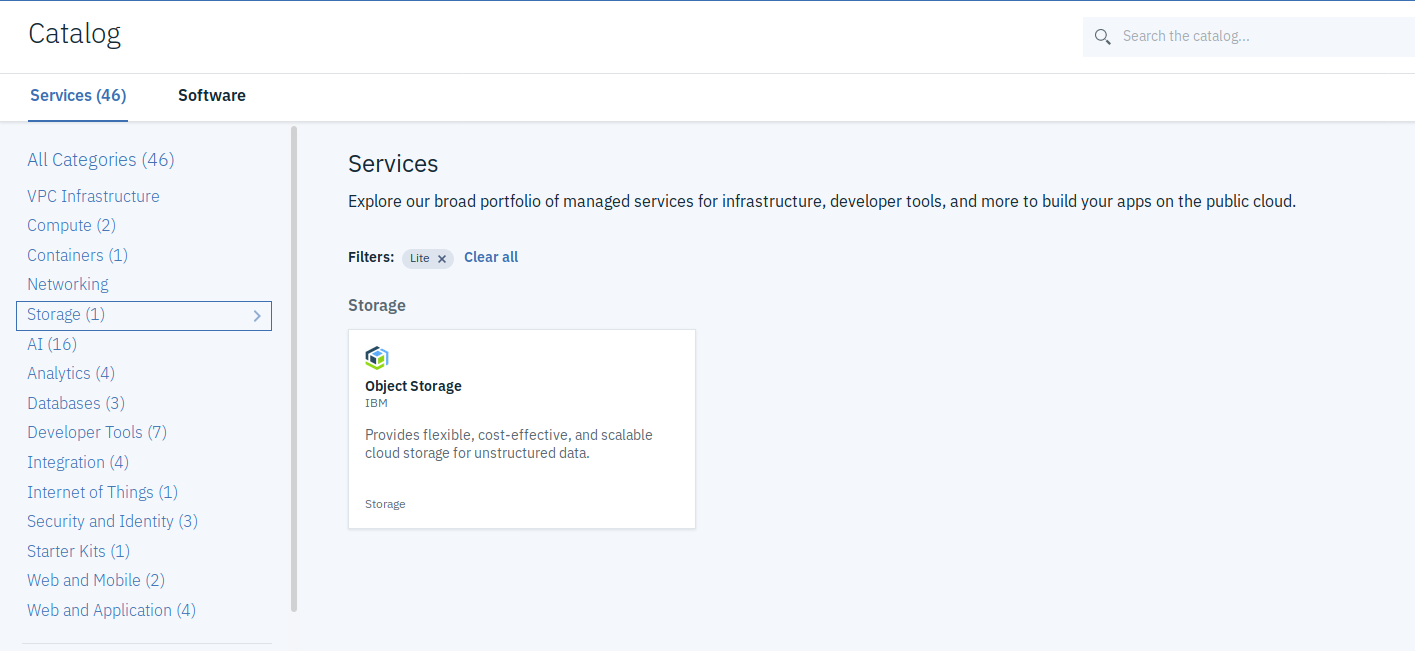


Select the `lite` plan, provide a Service Name (optional), and then click `Create`

On the next page, click `Create Bucket`

Select the option to create a **Custom Bucket**

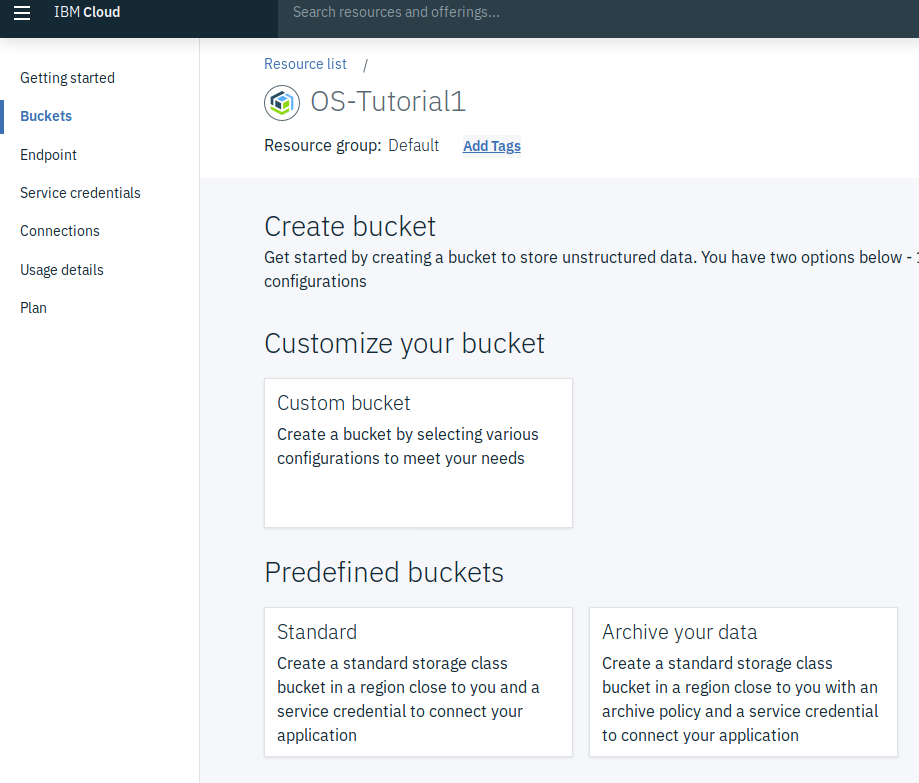

Provide a unique name (for example, one containing your username) 

## Important: Under `Resiliency` make sure you select "Cross Region"

### Under `Location` select your region.

### You may leave the remaining options as default

### Click `Create Bucket` at the lower right

## Upload Training Data

You should now see an empty bucket and a prompt to drag and drop files to upload.

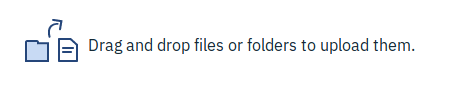

Locate the file `training_data.csv` that we created earlier in this tutorial. (It should be located in the same directory as this notebook.)  Drag and drop this to the bucket.

It should only take a few moments to upload this data.

### Leave this window open. You will need it for connection data.

## Connect the Training Data to OpenScale

We now need to link the training data in the Cloud Storage bucket to our model in OpenScale.

Return to the OpenScale Dashboard. Under `Model Details` it requests, "Specify the location of the training data."

Select `Cloud Object Storage` from the drop-down list.

To find the `Login URL`, return to the Cloud Object Storage webpage and select `Endpoint` from the column at left.

In the drop-down list for `Resiliency`, select `Cross Region` and select your Location from the locations drop-down.

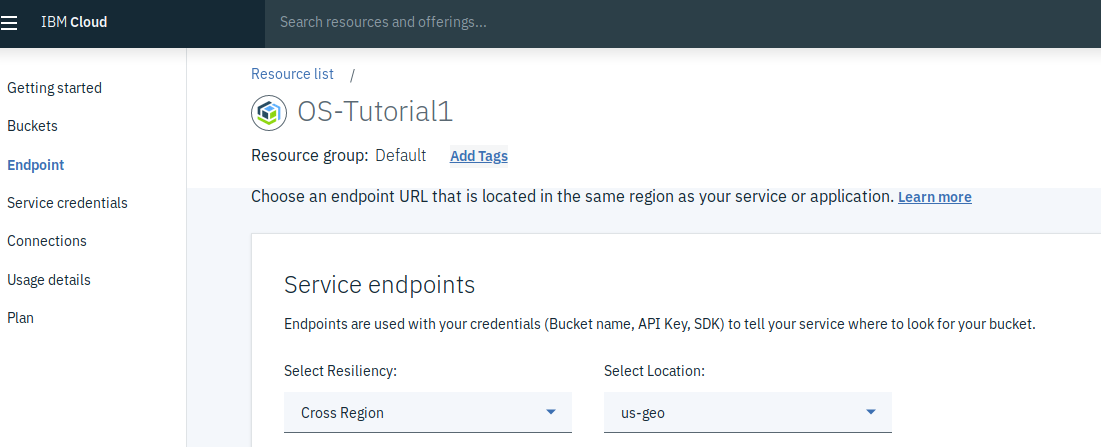

Select and copy the url for your endpoint. (In this tutorial, I am using us-geo, Public).

Return to the webpage for OpenScale and paste this url into `login url`.

### Important: you must add "https://" to the front of this url.

### Resource Instance ID

To locate your `Resource Instance ID`, return to the Cloud Storage webpage and select `Service Credentials` from the left column.

Next, select `New Credentials`.

On the `Add New Credential` dialog box, change the Role to `Manager` and click `Add`.

When the credentials appear, select `View credentials` under the `Actions` column.

You should now see a JSON object including "apikey", "endpoints", etc.

In this JSON, copy the value for resource_instance_id.  Paste this into the `Resource Instance ID` field in the OpenScale webpage.

Do the same for the "apikey" value in the JSON.

When these values have been entered into the OpenScale configuration, select `Test`.

After a couple of seconds, you should see: 

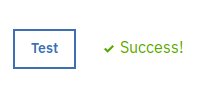

Click `Next` at the lower right.

### Select your bucket and training data set.

From the drop-down lists on the next page, select the bucket and training data set you have uploaded, and then click `Next`.

## Data Configuration

### OpenScale will now review the training data and associate the column labels.

Rememeber that our label column is called `*label*`, so as not to conflict with the word "label" if it were to appear in the corpus. OpenScale automatically identifies this column as the label column and asks to confirm. 

Select this column name and click `Next`

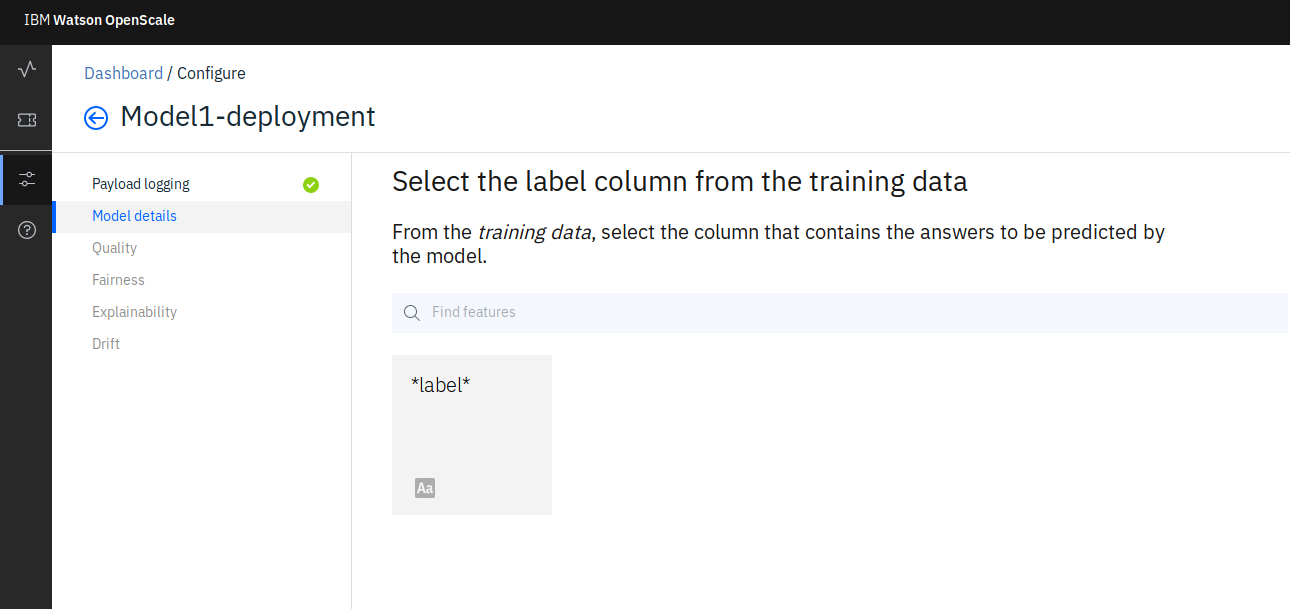

### Select the features used to train the AI Deployment

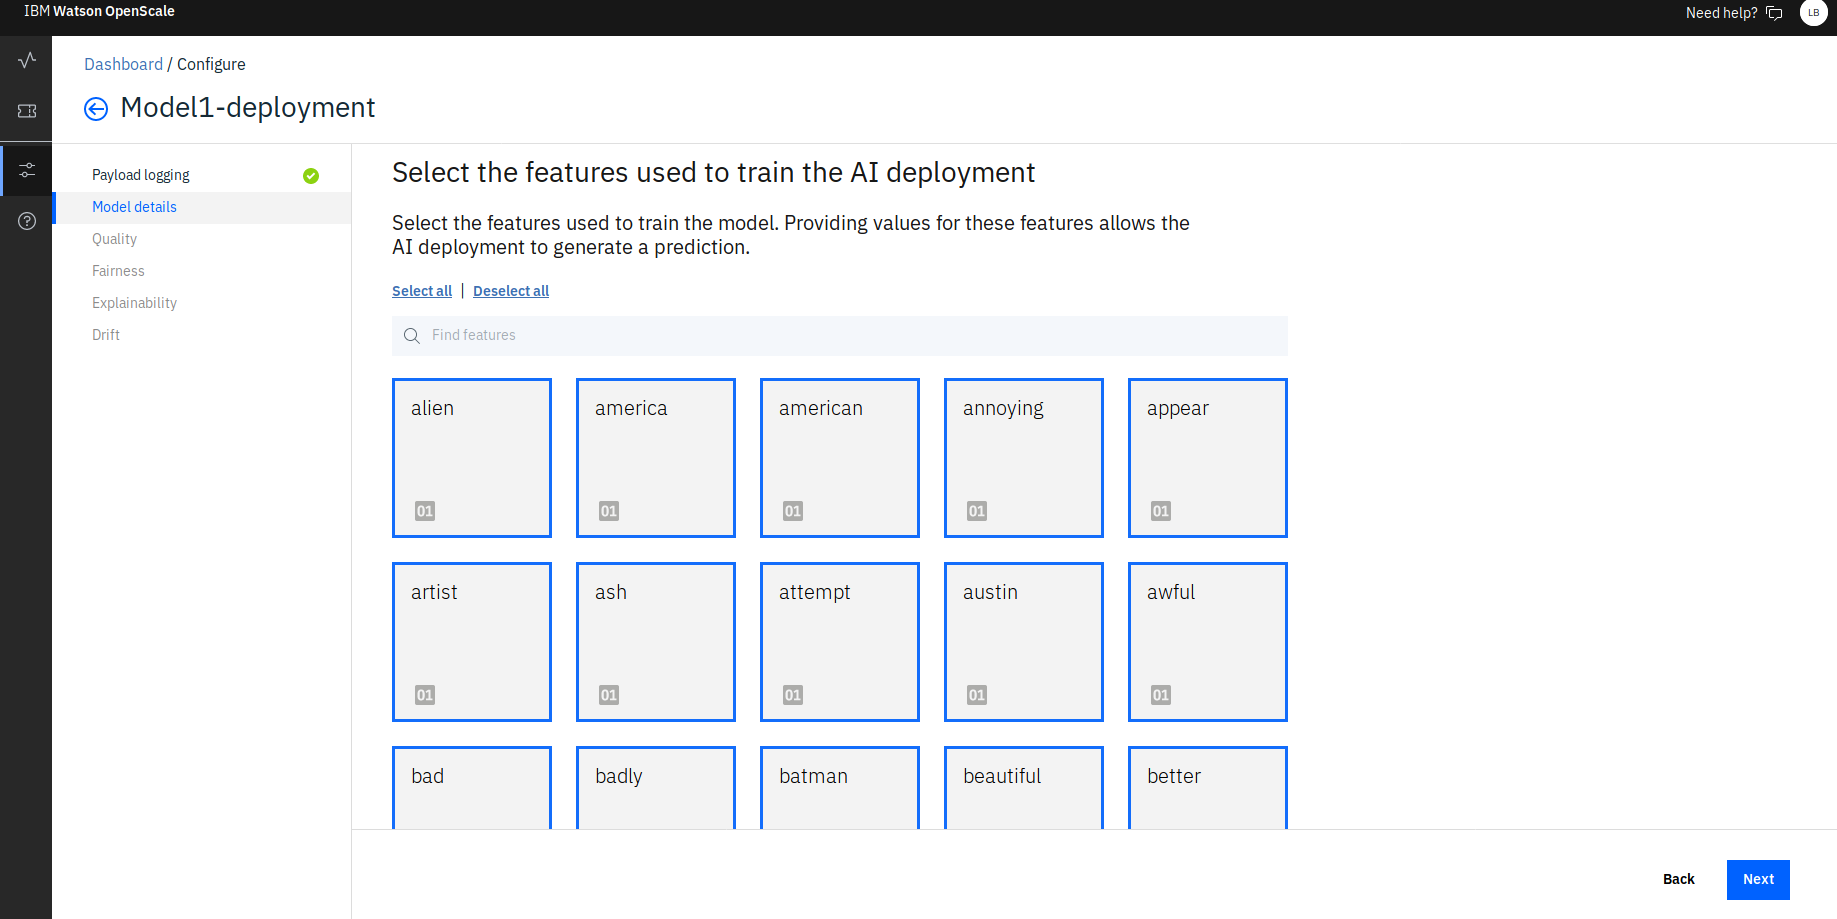


OpenScale again automatically identifies the *feature* columns. Make sure these are all selected and click `Next`.

### Select text and categorical features

In this model, we do not have any text or categorical features. All of our features have been reduced to a TF-IDF numeric matrix. 

Leave all these features unselected and click `Next`

### Select the deployment prediction column

This refers to the predictions created by our model *not* to a `predictions` column in our data set. Select the `predictions` option and click `Next`.

Do the same for `probabiltiy` on the following page.

We did not include a transcation ID in this model, so this optional column is left blank.

On the final page, review the **Models details summary** and click `Save`

After a few seconds, it should say:

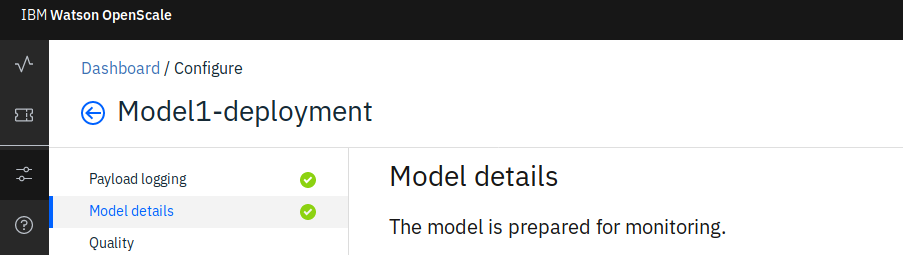

## Configuring Drift Monitor

The input to our model is plain text. We have not collected demographic information such as race, gender or nationality, so the Fairness monitoring tool is not applicable to this tutorial. 

We will use the Drift monitoring tool to monitor the deployed model over time.

Select `Drift` from the column at left and then `Begin` at lower right

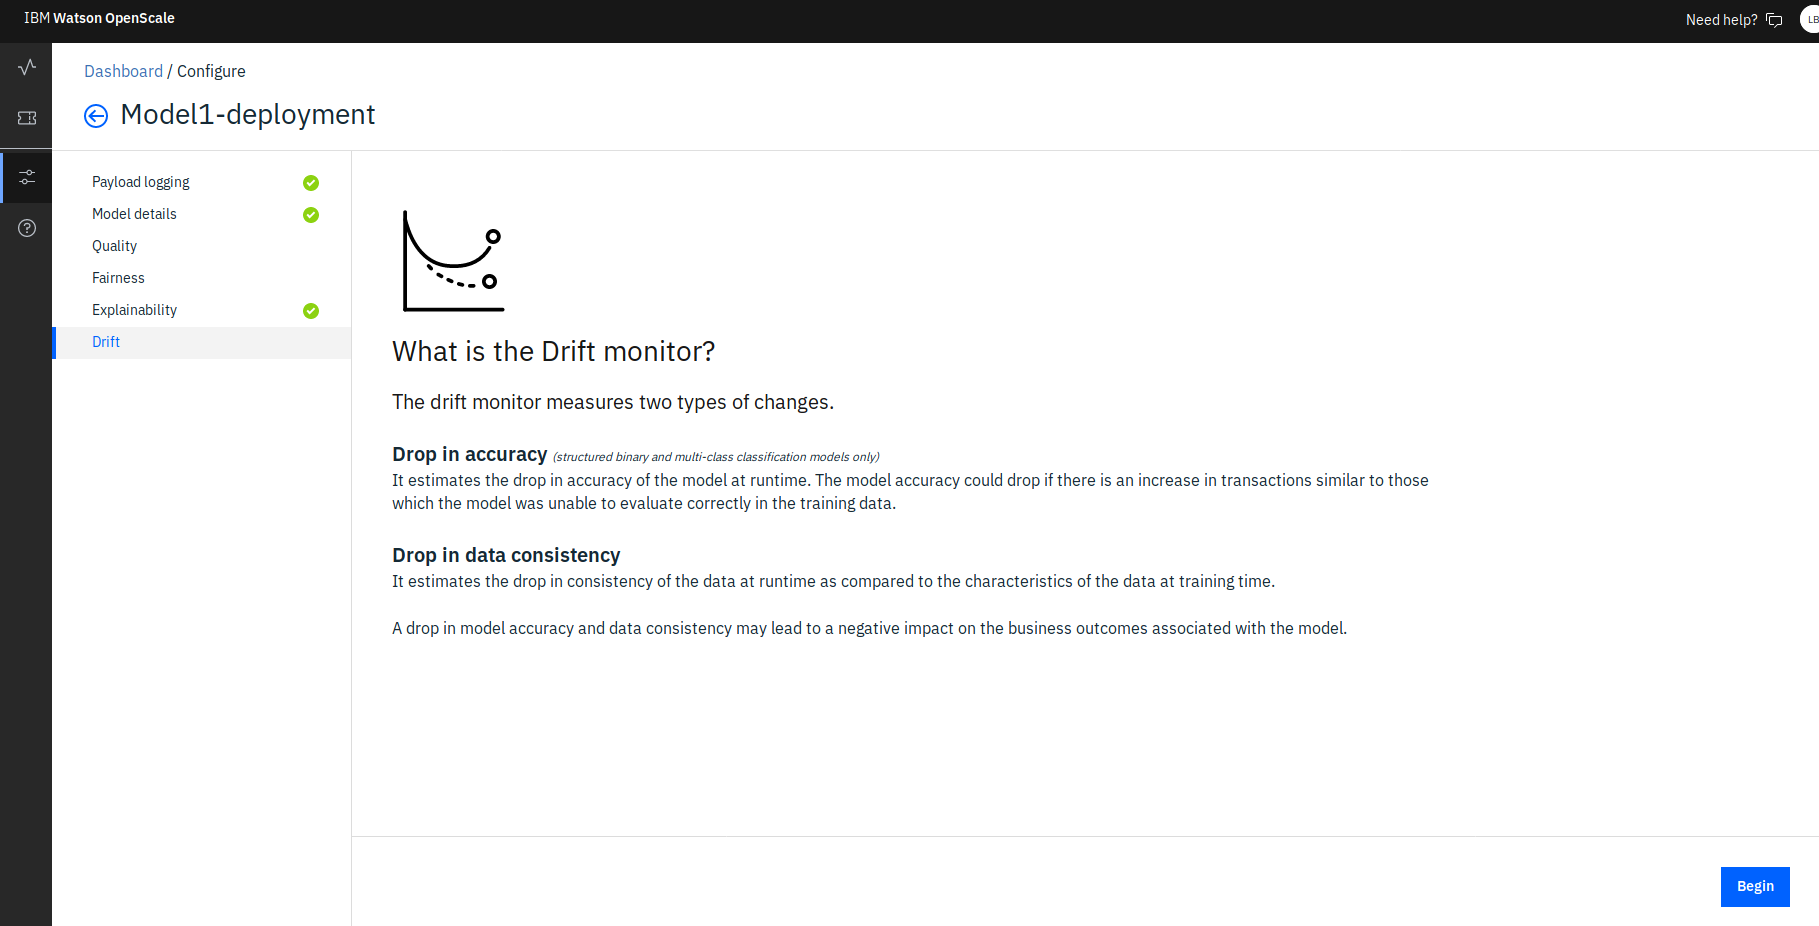

### Configure accuracy drift monitor

Select the option for `Analyze and train in Watson OpenScale` and click `Next`

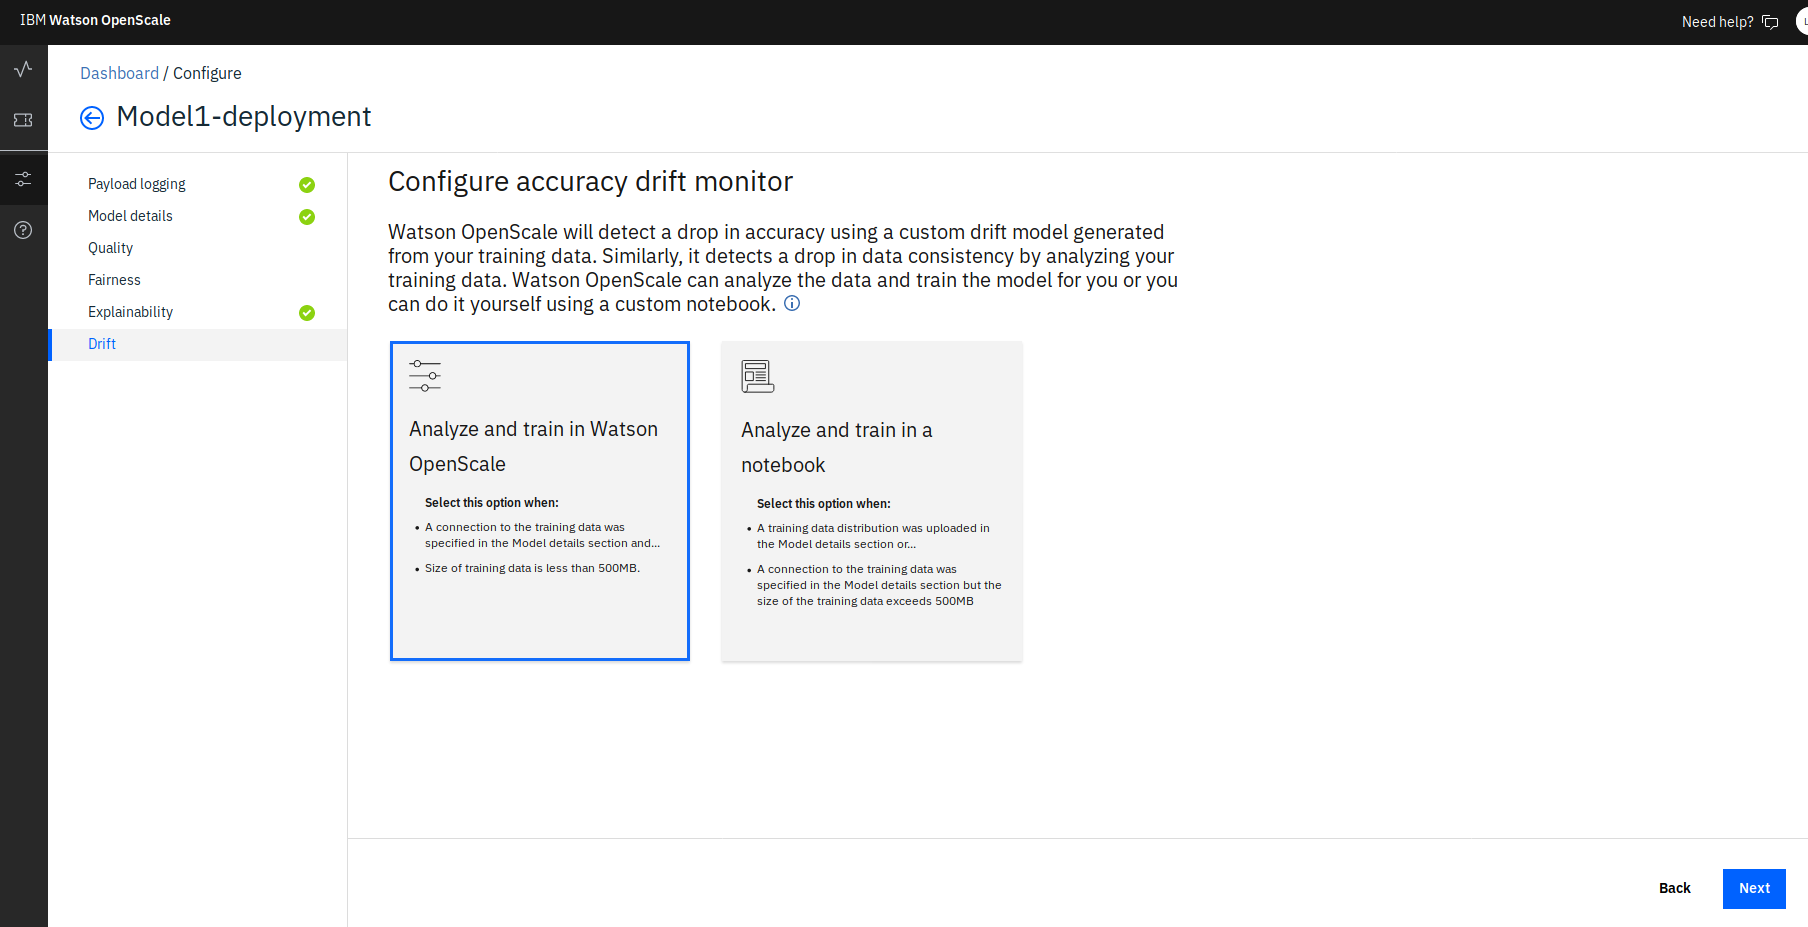

### Set the drift alert threshold
    
A drift alert threshold of 10% is the defualt. Lower values will make the system more sensitive to small amounts of drift, providing early warning of changes to data.

Click `Next`

Set the sample size on the next page and click `Next`

Review the settings for the Drift monitor on the final page and click `Save`.

It may take ten to twenty minutes to configure and train the drift monitor.

## Deployment Monitoring

After the Drift monitor is trained, you can return to the IBM Watson OpenScale dashboard and monitor the performance of the model over time as additional transactions are made.

Note that quality and fairness metrics update once per hour and drift updates once every three hours.